In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Eye Paper/data"
classes = ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']

Mounted at /content/drive


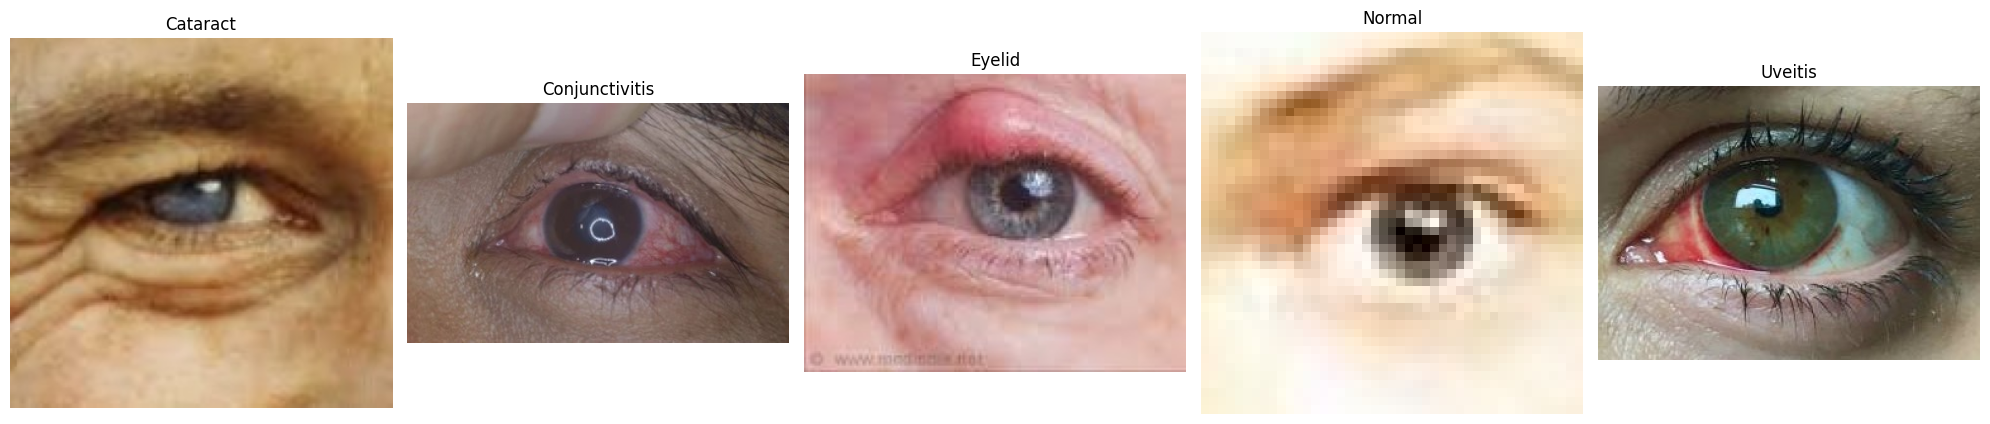

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def visualize_dataset_example(base_path, classes):
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))
    for i, cls in enumerate(classes):
        folder = os.path.join(base_path, cls)
        img_name = os.listdir(folder)[0]
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(cls)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_dataset_example(dataset_path, classes)

In [ ]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.1 MB/s eta 0:00:00


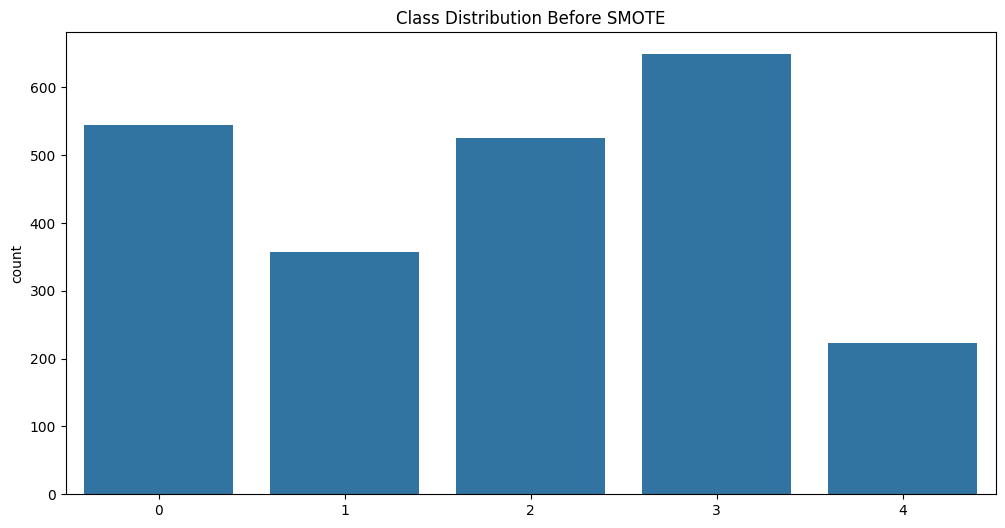

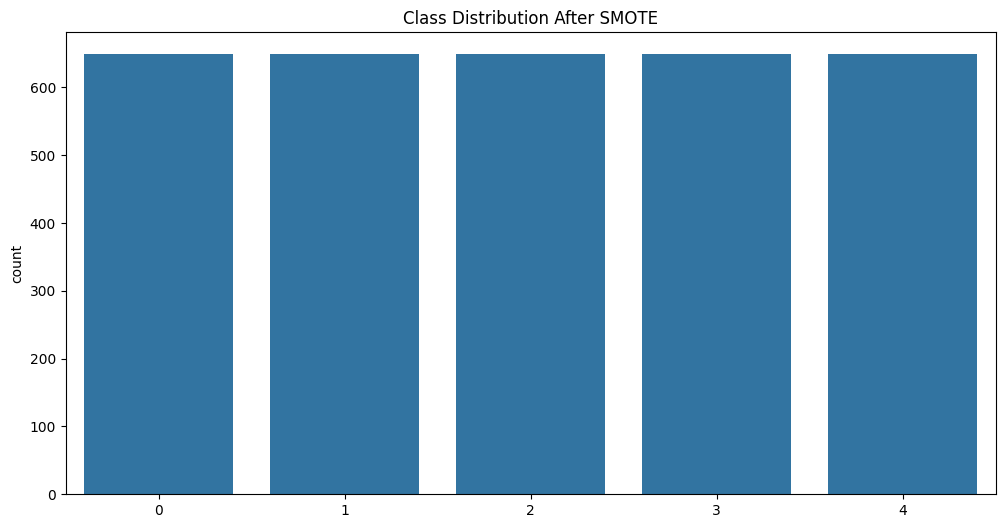

In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns

data = []
labels = []

for cls_id, cls_name in enumerate(classes):
    folder = os.path.join(dataset_path, cls_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        data.append(img)
        labels.append(cls_id)

data = np.array(data)
labels = np.array(labels)

data_flat = data.reshape(len(data), -1)

smote = SMOTE(random_state=42)
data_balanced, labels_balanced = smote.fit_resample(data_flat, labels)

data_balanced = data_balanced.reshape(-1, 224, 224, 3)

def visualize_class_distribution(labels_before, labels_after):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_before)
    plt.title("Class Distribution Before SMOTE")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_after)
    plt.title("Class Distribution After SMOTE")
    plt.show()

visualize_class_distribution(labels, labels_balanced)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_balanced, labels_balanced, test_size=0.2, random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class EyeDiseaseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img).permute(2, 0, 1) / 255.0
        return img.float(), label

train_dataset = EyeDiseaseDataset(train_data, train_labels, transform=transform)
test_dataset = EyeDiseaseDataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)